In [45]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Intuition behind Derivatives

In [46]:
def f(x):
    return 3*x**2 - 4*x + 5

In [47]:
f(3.0)


20.0

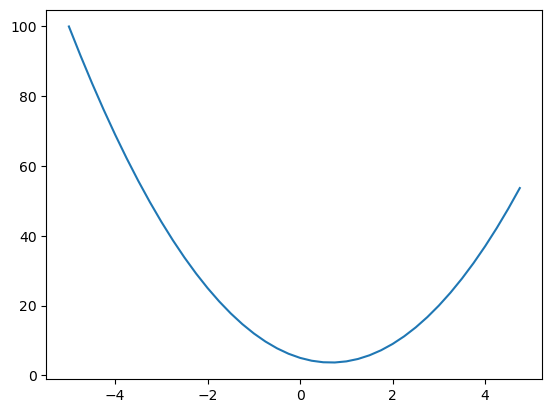

In [48]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

## Differentiation for Univariate Functions

### Definition: *Derivative*

For $h \gt 0$ the *derivative* of $f$ at $x$ is defined as the limit

$$
\frac{df}{dx} := \lim_{h \to 0} \frac{ f(x + h) - f(x) }{ h }
$$


In [49]:
# For f(x) at x = 2/3:
h = 0.000001
x = 2/3
print((f(x + h) - f(x)) / h)

2.999378523327323e-06


## Partial Differentiation and Gradients

### Definition: *Partial Derivative*

For a function $f : \mathbb{R}^2 \to \mathbb{R}, \, \mathbf{x} \mapsto f(\mathbf{x}), \mathbf{x} \in \mathbb{R}^n$ of $n$ variables $x_1, \dots, x_n$ we define the *partial derivative* as 

$$
\frac{\partial f}{\partial x_1} = \lim_{h \to 0} \frac{ f(x_1 + h, x_2, \dots, x_n ) - f( \mathbf{x} ) }{ h }
$$
$$
\vdots
$$
$$
\frac{\partial f}{\partial x_n} = \lim_{h \to 0} \frac{ f(x_1, x_2, \dots, x_n + h ) - f( \mathbf{x} ) }{ h }
$$

and collect them in the new row vector

$$
\nabla_x f = \text{grad} f = \frac{\partial f}{\partial \mathbf{x}} =  \begin{bmatrix}
\frac{\partial f}{\partial x_1} & \frac{\partial f}{\partial x_2} & \dots & \frac{\partial f}{\partial x_n}
\end{bmatrix} \in \mathbb{R}^{1 \times n}
$$


In [50]:
# Multivariate function f(a, b, x) = a * b + c  

def f(a, b, c):
    return a*b + c

a = 2.0
b = -3.0
c = 10.0
d = f(a, b, c)
print(d)

4.0


In [51]:
# Partial derivatives for f with respect to a

h = 0.00001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = f(a, b, c)
d2 = f(a+h, b, c)

print("d1", d1)
print("d2", d2)
print("Derivative w. r. to a =", ((d2 - d1) / h))

d1 4.0
d2 3.9999699999999994
Derivative w. r. to a = -3.000000000064062


*The partial derivative with respect to $a$ of $f$ at $a=2, b=-3, c=10$ is -3.*

*Proving this with the analytical approach gives us $\frac{\partial f}{\partial a} = b$.*

In [52]:
# Partial derivatis for f with respect to b & c

h = 0.00001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d3 = f(a, b+h, c)
d4 = f(a, b, c+h)

print("d3", d3)
print("Derivative w. r. to b =", ((d3 - d1) / h))
print("d3", d4)
print("Derivative w. r. to c =", ((d4 - d1) / h))

d3 4.00002
Derivative w. r. to b = 2.0000000000131024
d3 4.00001
Derivative w. r. to c = 0.9999999999621422


$$\frac{\partial f}{\partial b} = a$$

$$\frac{\partial f}{\partial c} = 1$$

# Neural Networks

In [53]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"{self.label if self.label is not None else 'NoName'}: {self.data}"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad = out.grad
            other.grad = out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        out._backward = _backward
        return out

    def tanh(self):
        t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out = Value(t, (self, ), "tanh")
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def copy(self):
        return Value(self.data, self._prev, self._op, self.label)

In [54]:
from graphviz import Digraph

def trace(root):
    nodes , edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Manual Backpropagation for the Function

$$
L(a, b, c, d) = ((a \times b) + c) \times d
$$

Or

$$
L(a, b, c, d) = L(f(e(a, b), c), d), 
$$

with

$$
e(a, b) = a \times b, 
$$
$$
f(e, c) = e + c, 
$$
$$
L(f, d) = f \times d
$$

### Building the Computation Graph

In [55]:
# Input
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10, label="c")
d = Value(-2.0, label="d")

# Itermetiate nodes
e = a * b; e.label = "e"
f = e + c; f.label = "f"
L = f * d; L.label = "L"

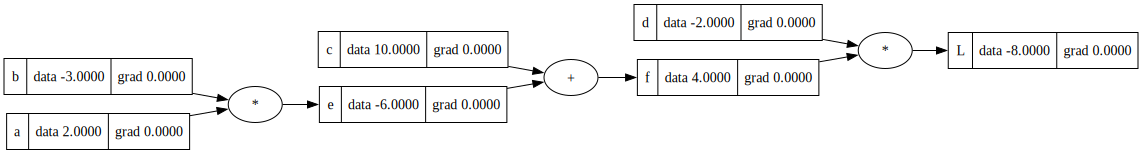

In [56]:
draw_dot(L)

### Backpropagation Step 1: **L**

The derivative of L with respect to L is 1.
$$ \frac{\partial L}{\partial L} = 1.0 $$
$$ \frac{\partial \text{ dependant var}\ }{\partial \text{ independant var}\ } = derivative $$

0.9999999999976694


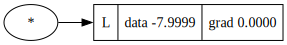

In [57]:
def partial_using_lim(dependent_var, independent_var, h=1e-4):
    list_of_values = [dependent_var.copy()]
    val1 = list_of_values[0].data

    def _copy_graph(current_value, independent_var, list_of_values):
        children = list(current_value._prev)
        if current_value.label == independent_var.label:
            current_value.data += h
            current_value._prev = set()
        elif len(children) == 1:
            new_children = [children[0].copy()]
            list_of_values.append(new_children[0])
            current_value._prev = set(new_children)
            list_of_values = _copy_graph(new_children[0], independent_var, list_of_values)
        elif len(children) > 1:
            order = [1, 0]
            if children[0]._prev == set():
                order = [0, 1]
            new_children = [children[order[i]].copy() for i in range(2)]
            list_of_values.append(new_children[0])
            list_of_values.append(new_children[1])
            current_value._prev = set(new_children)
            list_of_values = _copy_graph(new_children[0], independent_var, list_of_values)
            list_of_values = _copy_graph(new_children[1], independent_var, list_of_values)
        return list_of_values
    
    def _update_graph(value):
        if value._prev != set():
            children = list(value._prev)
            for child in children:
                _update_graph(child)
            if value._op == "*":
                value.data = children[0].data * children[1].data
            elif value._op == "+":
                value.data = children[0].data + children[1].data
            elif value._op == "tanh":
                value.data = (math.exp(2*children[0].data) - 1) / (math.exp(2*children[0].data) + 1)
    
    list_of_values = _copy_graph(list_of_values[0], independent_var, list_of_values)
    _update_graph(list_of_values[0])
    val2 = list_of_values[0].data

    return draw_dot(list_of_values[0]), ((val2 - val1) / h)

dot, derivative = partial_using_lim(L, L)
print(derivative)
dot


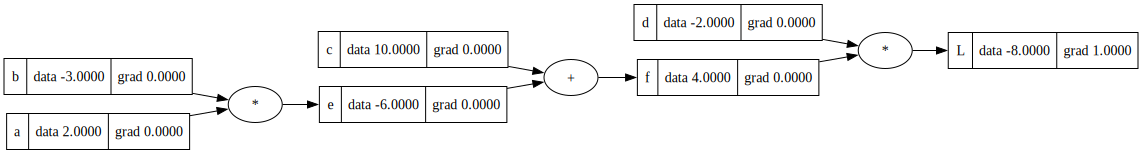

In [58]:
L.grad = 1.0
draw_dot(L)

### Backpropagation Step 2: **d** & **f**

Knowing that $L(f, d) = f \times d$, we can calculate the derivatives simply as

$$
\frac{ \partial L }{ \partial d} = f
$$

and 

$$
\frac{\partial L}{\partial f} = d
$$

3.9999999999995595


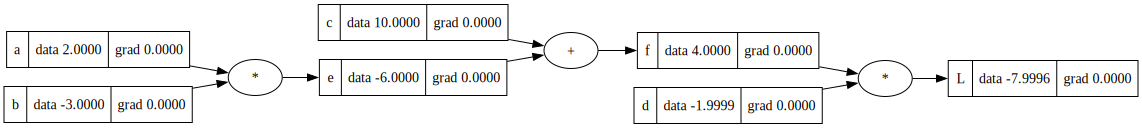

In [59]:
# For d:

dot, derivative = partial_using_lim(L, d)
print(derivative)
dot

-1.9999999999953388


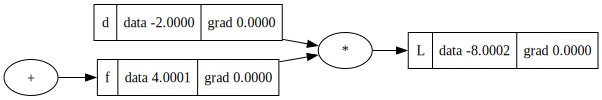

In [60]:
# For f:

dot, derivative = partial_using_lim(L, f)
print(derivative)
dot

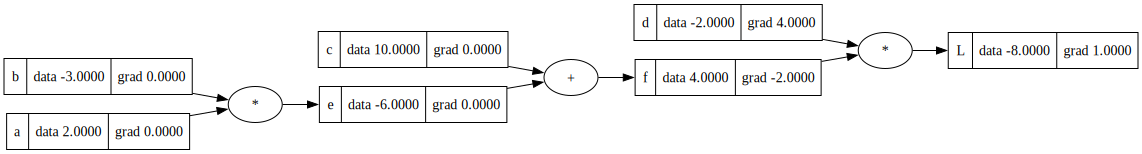

In [61]:
d.grad = f.data # = -2
f.grad = d.data # = 4
draw_dot(L)

### Backpropagation Step 3: **c** & **e**

In order to find the derivative $\frac{\partial L}{\partial e}$, we will first calculate the partial derivative $\frac{\partial f}{\partial e}$.

Since we know that $f(e, c) = e + c$, we can simply derive f as

$$\frac{\partial f}{\partial e} = 1$$

0.9999999999976694


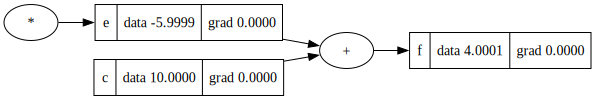

In [62]:
dot, derivative = partial_using_lim(f, e)
print(derivative)
dot

The same goes for $c$:
$$\frac{ \partial f }{ c } = 1$$

0.9999999999976694


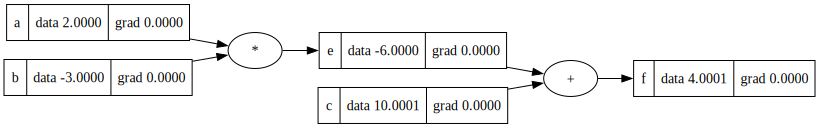

In [63]:
dot, derivative = partial_using_lim(f, c)
print(derivative)
dot

#### Chain Rule

$$\frac{\partial y}{\partial x} = \frac{\partial y}{\partial u} \frac{\partial u}{\partial x}$$


Therefore we can simply calculate $\frac{\partial L}{\partial c}$ and $\frac{\partial L}{\partial e}$ with the chain rule:

$$\frac{\partial L}{\partial c} = \frac{\partial L}{\partial f} \frac{\partial f}{\partial c} = -2 \times 1 = -2$$
$$\frac{\partial L}{\partial e} = \frac{\partial L}{\partial f} \frac{\partial f}{\partial e} = -2 \times 1 = -2$$




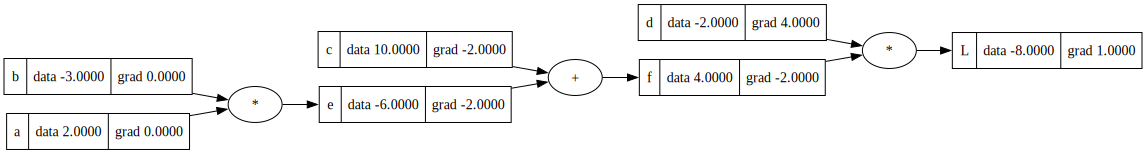

In [64]:
# Applying the gradients:
c.grad = e.grad = -2.0
draw_dot(L)

### Backpropagation Step 4: $a$ & $b$

We will again first calculate the partial derivatives $\frac{\partial e}{\partial a}$ and $\frac{\partial e}{\partial b}$.
Since we know that $e(a, b) = a \times b$, we can derive them manually again:

$$\frac{\partial e}{\partial a} = b = -3$$
$$\frac{\partial e}{\partial b} = a = 2$$



-3.000000000010772


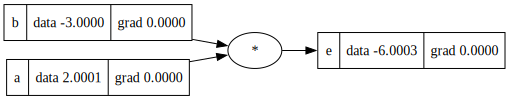

In [65]:
# For a
dot, derivative = partial_using_lim(e, a)
print(derivative)
dot

2.0000000000042206


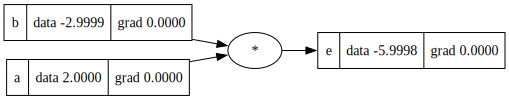

In [66]:
# for b
dot, derivative = partial_using_lim(e, b)
print(derivative)
dot

Calculating the gradient using the chain rule gives us:

$$\frac{\partial L}{\partial a} = \frac{\partial L}{\partial e} \frac{\partial e}{\partial a} = -2 \times -3 = 6$$
$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial e} \frac{\partial e}{\partial b} = -2 \times 2 = -4$$



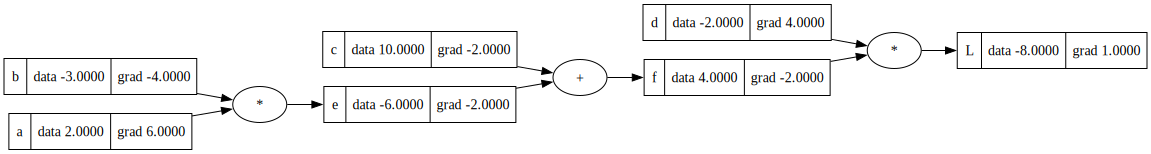

In [67]:
# Applying the gradients
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

# Manual Backprop for a *Perceptron*

A perceptron is a simplified mathematical model of a biological neuron. It is defined as such:
$$perceptron(\mathbf{x}) = f(\mathbf{w}\mathbf{x} + b),$$
where
- $\mathbf{x}$ is the input vector
- $\mathbf{w}$ is the weight vector
- $b$ is the bias scalar
- $f(x)$ is the activation function

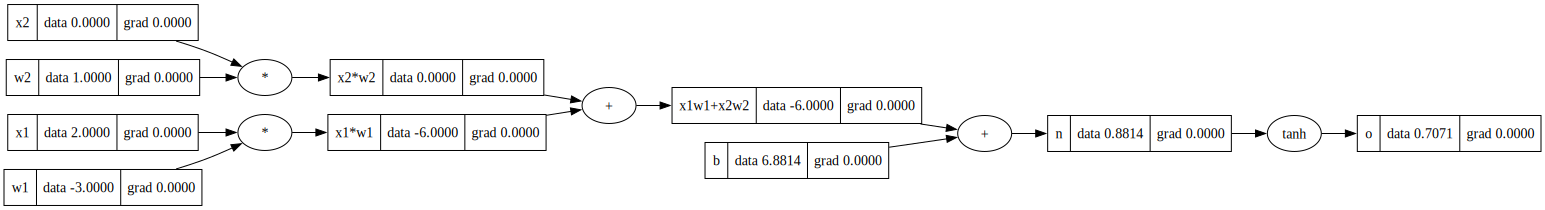

In [68]:
# Perceptron inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights w1, w2, and bias b
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
# n = x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"#
o = n.tanh(); o.label = "o"
draw_dot(o)

## Backpropagation Step 1: o

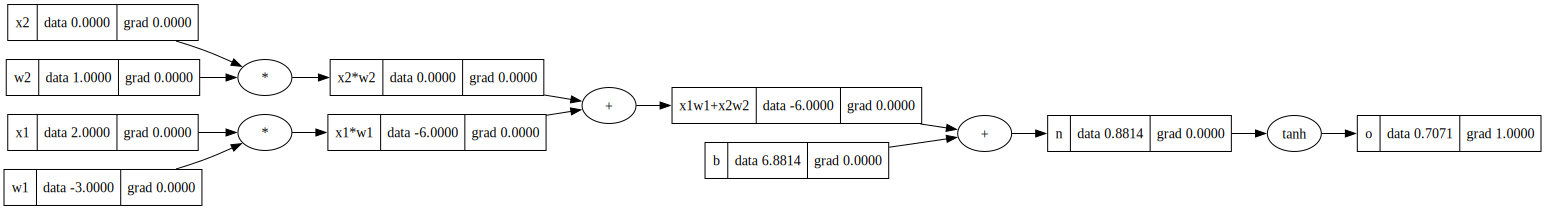

In [69]:
o.grad = 1
draw_dot(o)

## Backpropagation Step 2: n

We know that the derivative of $tanh(x)$ is equal to $1 - tanh^2(x)$. Therefor we can calculate

$$\frac{\partial o}{\partial n} = 1 - o^2 = 1 - 0.7071^2 = 0.5$$

0.4999646454939555


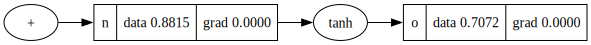

In [70]:
dot, derivative = partial_using_lim(o, n)
print(derivative)
dot

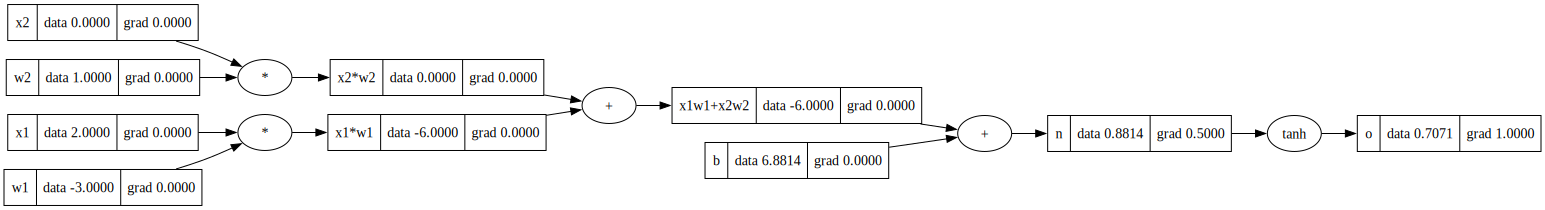

In [71]:
# Applying the gradient
n.grad = 0.5
draw_dot(o)

## Backpropagation Step 3: b & x2w1+x2w2

Since we have discovered that a plus operation simply distributes the gradient of the function it is embedded in, we can simply say:
$$\frac{\partial o}{\partial b} = \frac{\partial o}{\partial n} = 0.5$$
$$\frac{\partial o}{\partial x1w1+x2w2} = \frac{\partial o}{\partial n} = 0.5$$

In [72]:
dot, derivative = partial_using_lim(o, b)
print(derivative)

0.49996464549284525


In [73]:
dot, derivative = partial_using_lim(o, x1w1x2w2)
print(derivative)

0.49996464549284525


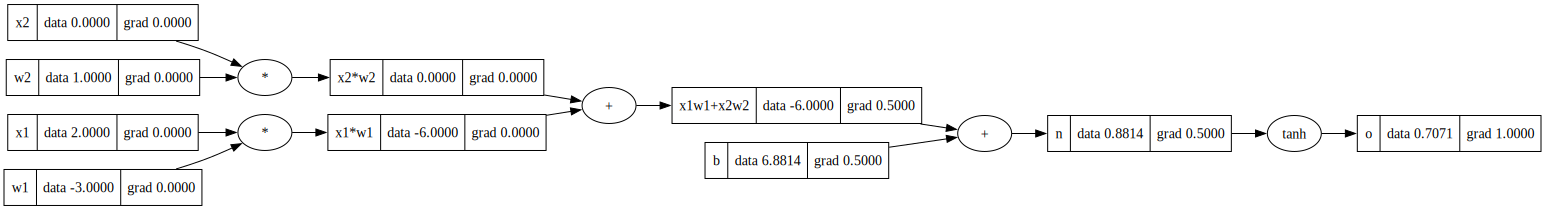

In [74]:
# Applying the gradients
b.grad = x1w1x2w2.grad = 0.5
draw_dot(o)

## Backpropagation Step 4: x1*w1 & x2*w2

The same goes for this operation:
$$\frac{\partial o}{\partial \text{x1*w1}} = \frac{\partial o}{\partial b} = \frac{\partial o}{\partial n} = 0.5$$
$$\frac{\partial o}{\partial \text{x2*w2}} = \frac{\partial o}{\partial \text{x1w1+x2w2}} = \frac{\partial o}{\partial n} = 0.5$$

In [75]:
dot, derivative = partial_using_lim(o, x1w1)
print(derivative)

0.49996464549284525


In [76]:
dot, derivative = partial_using_lim(o, x2w2)
print(derivative)

0.49996464549284525


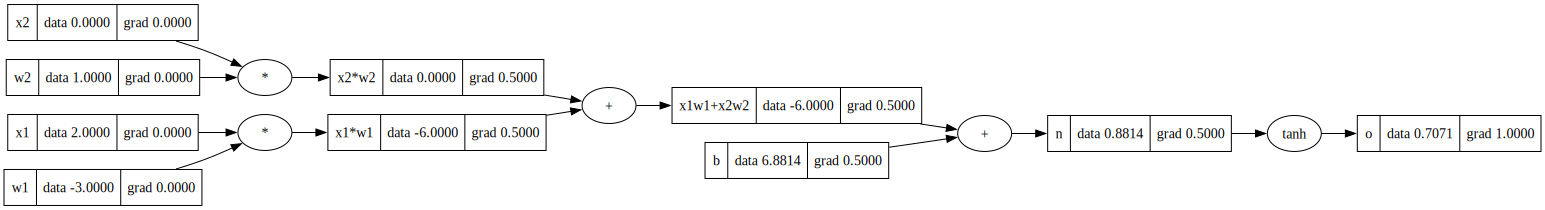

In [77]:
# Applying the gradients
x1w1.grad = x2w2.grad = 0.5
draw_dot(o)

## Backpropagation Step 5: x1 & w1

To find the derivative $\frac{\partial o}{\partial x1}$ and $\frac{\partial o}{\partial x2}$, we first need to find the partial derivatives of $\frac{\partial \text{x1*w1}}{\partial x1}$ and $\frac{\partial \text{x1*w1}}{\partial w1}$. //
We know that the derivative of a multiplication like $f(a, b) = a \times b$ with respect to $a$ is $b$. Therefor we can simply calculate the derivatives using the chain rule:
$$\frac{\partial o}{\partial x1} = \frac{\partial o}{\partial \text{x1*w1}} \frac{\partial \text{x1*w1}}{\partial x1} = 0.5 \times -3.0 = -1.5$$
$$\frac{\partial o}{\partial w1} = \frac{\partial o}{\partial \text{x1*w1}} \frac{\partial \text{x1*w1}}{\partial w1} = 0.5 \times 2.0 = 1.0$$


In [78]:
dot, derivative = partial_using_lim(o, x1)
print(derivative)

-1.500318220551966


In [79]:
dot, derivative = partial_using_lim(o, w1)
print(derivative)

0.9998585853132624


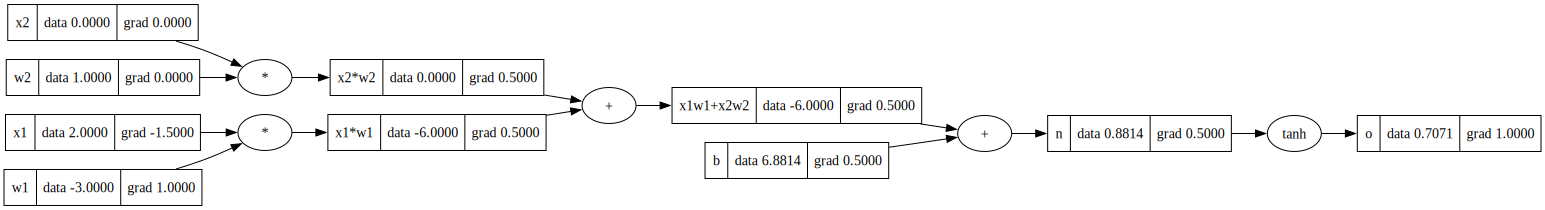

In [80]:
# Applying the gradients
x1.grad = -1.5
w1.grad = 1.0
draw_dot(o)

## Backpropagation Step 6: x2 and w2
Equivalent to *Step 5*.
$$\frac{\partial o}{\partial x2} = 0.5 \times 1.0 = 0.5$$
$$\frac{\partial o}{\partial w2} = 0.5 \times 0.0 = 0.0$$


In [81]:
dot, derivative = partial_using_lim(o, x2)
print(derivative)

0.49996464549284525


In [82]:
dot, derivative = partial_using_lim(o, w2)
print(derivative)

0.0


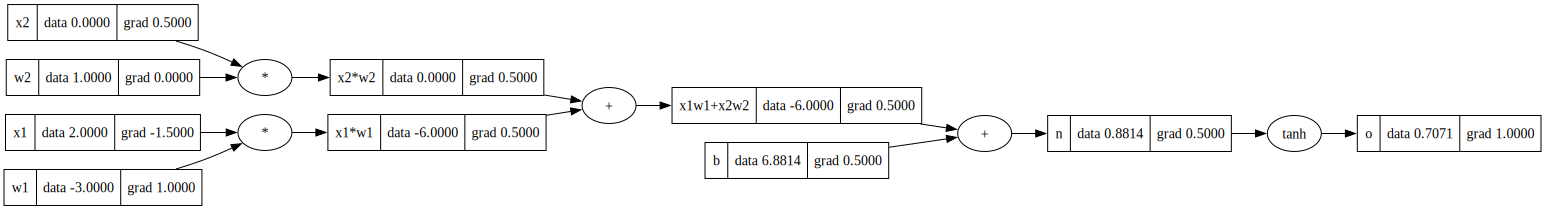

In [83]:
# Applying the gradients
x2.grad = 0.5
w2.grad = 0.0
draw_dot(o)

## Backprop with Autodifferentiation

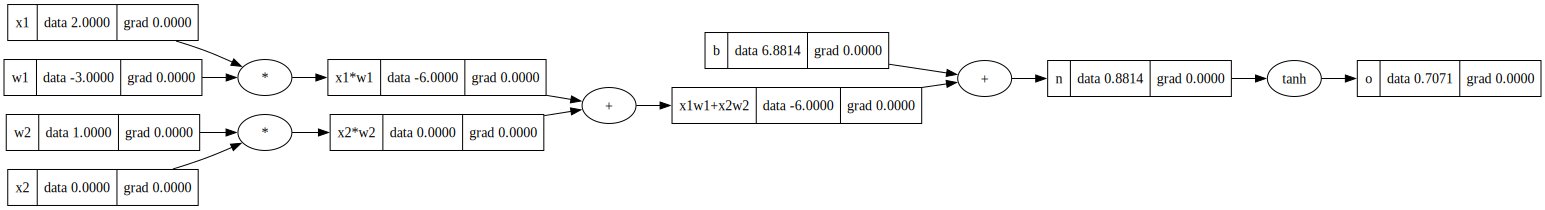

In [84]:
# Perceptron inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights w1, w2, and bias b
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
# n = x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"#
o = n.tanh(); o.label = "o"
draw_dot(o)

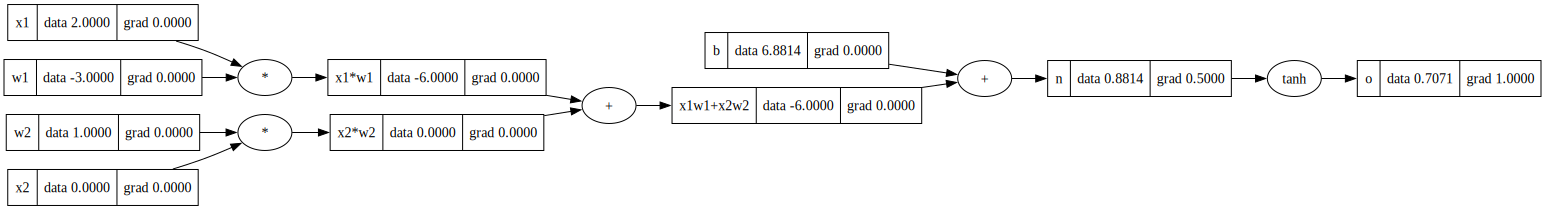

In [85]:
o.grad = 1.0
o._backward()
draw_dot(o)

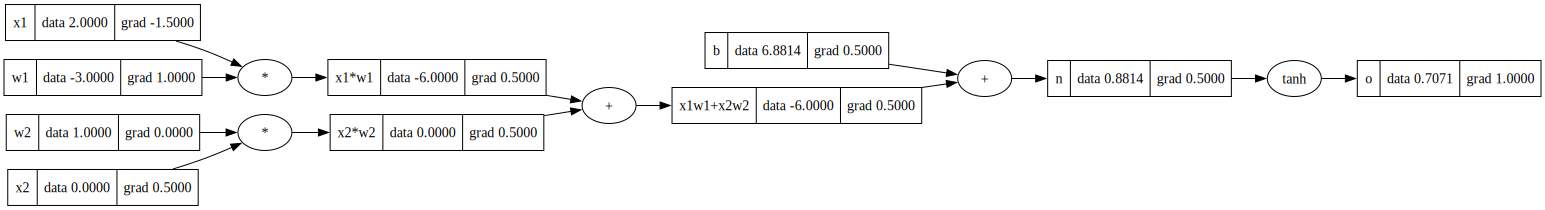

In [86]:
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
w1._backward()
x2._backward()
w2._backward()
draw_dot(o)